In [11]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

In [12]:
# LOAD DATA

ball_df = pd.read_csv("IPL_BallByBall2008_2024(Updated) (1).csv")
team_info_df = pd.read_csv("team_performance_dataset_2008to2024.csv")
player_info_df = pd.read_csv("Players_Info_2024.csv")
match_df = pd.read_csv("ipl_teams_2024_info.csv")

print(ball_df.shape, team_info_df.shape, player_info_df.shape, match_df.shape)

(255759, 19) (1073, 18) (245, 10) (10, 7)


C:\Users\user5\AppData\Local\Temp\ipykernel_6872\3100679314.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  ball_df = pd.read_csv("IPL_BallByBall2008_2024(Updated) (1).csv")


In [13]:
# CLEANING 

ball_df.columns = ball_df.columns.str.strip().str.lower().str.replace(' ', '_')

team_info_df.columns = team_info_df.columns.str.strip().str.lower().str.replace(' ', '_')

In [14]:
# COMBINING

merged_df = ball_df.merge(team_info_df[['match_id', 'venue', 'toss_winner', 'toss_decision', 'match_winner', 'win_type', 'win_margin']],left_on='match_id',right_on= "match_id",how='left')

In [15]:
print(merged_df.shape)

(255759, 25)


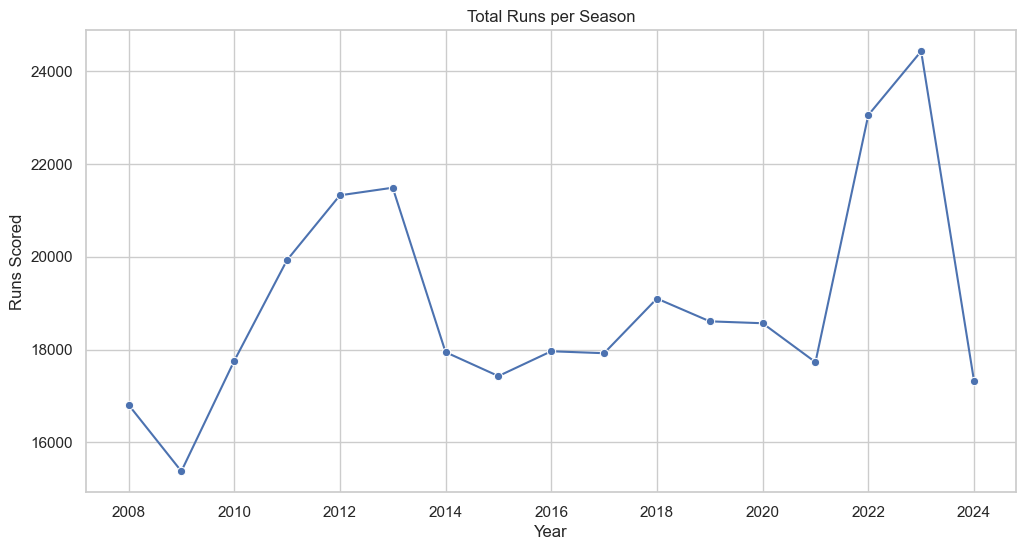

In [16]:
# ANALYZE RUN TRENDS OVER YEARS

ball_df['date'] = pd.to_datetime(ball_df['date'])
ball_df['year'] = ball_df['date'].dt.year

runs_per_season = ball_df.groupby('year')['runs_scored'].sum().reset_index()

plt.figure()
sns.lineplot(x='year', y='runs_scored', data=runs_per_season, marker='o')
plt.title('Total Runs per Season')
plt.xlabel('Year')
plt.ylabel('Runs Scored')
plt.show()

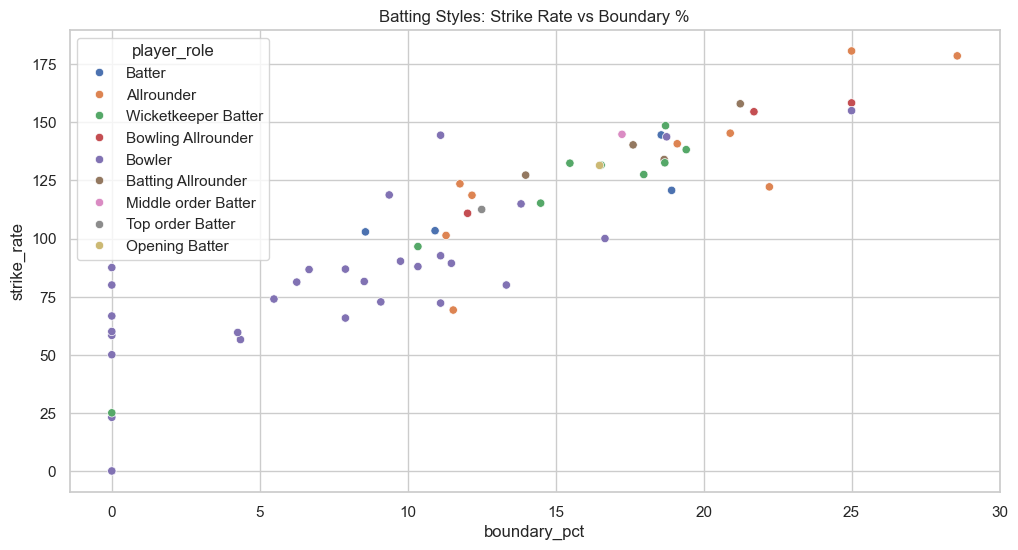

In [17]:
# COMPARE BATTING STYLES

ball_df['is_boundary'] = ball_df['runs_scored'].apply(lambda x: 1 if x in [4,6] else 0)

batter_stats = ball_df.groupby('striker').agg({
    'runs_scored': 'sum',
    'ball_no': 'count',
    'is_boundary': 'sum'
}).reset_index()

batter_stats['strike_rate'] = (batter_stats['runs_scored'] / batter_stats['ball_no']) * 100
batter_stats['boundary_pct'] = (batter_stats['is_boundary'] / batter_stats['ball_no']) * 100

player_info_df.columns = player_info_df.columns.str.strip().str.lower().str.replace(' ', '_')
batter_stats = batter_stats.merge(player_info_df, left_on='striker', right_on='player_name', how='left')

plt.figure()
sns.scatterplot(x='boundary_pct', y='strike_rate', hue='player_role', data=batter_stats)
plt.title('Batting Styles: Strike Rate vs Boundary %')
plt.show()

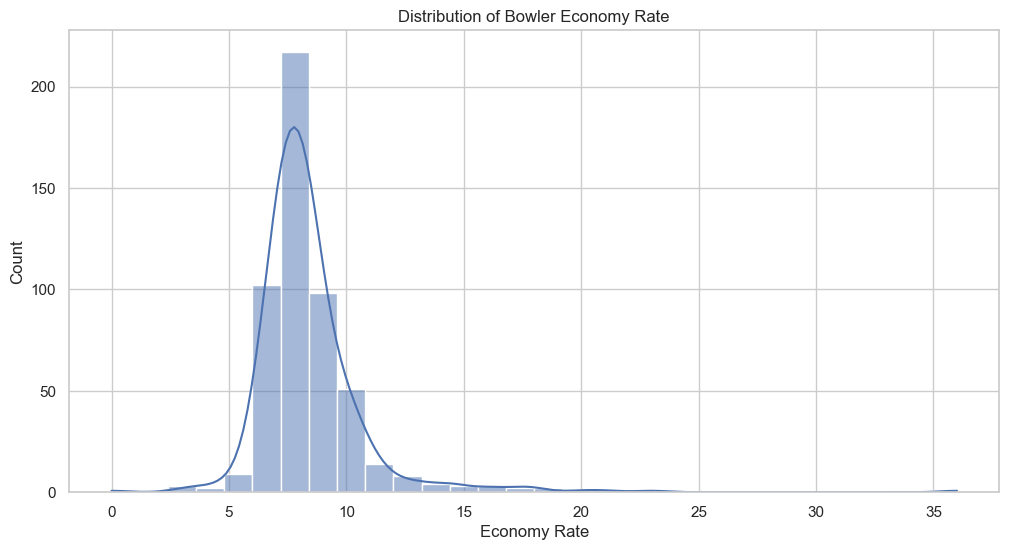

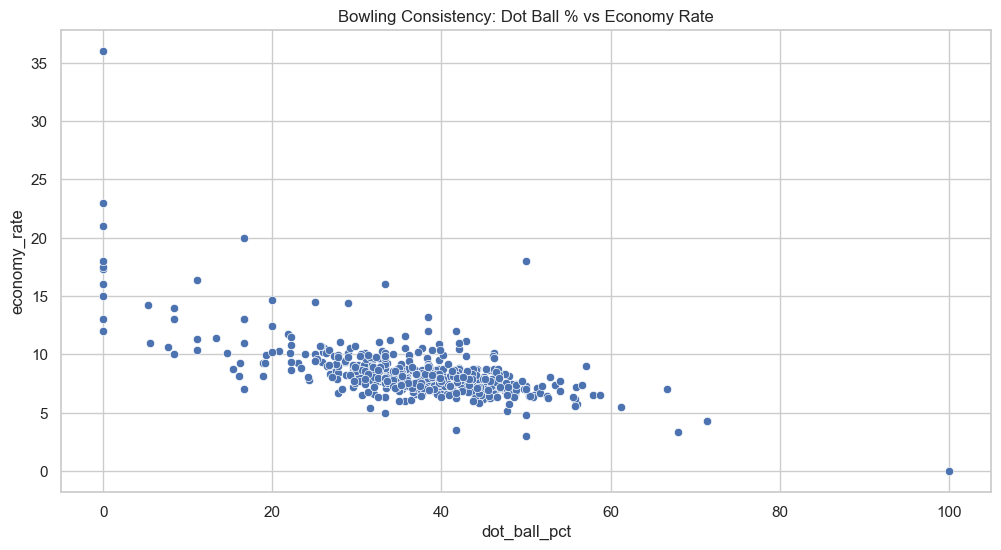

In [18]:
# BOWLING CONSISTENCY

ball_df['is_dot'] = np.where(ball_df['runs_scored']==0, 1, 0)

bowler_stats = ball_df.groupby('bowler').agg({
    'runs_scored': 'sum',
    'ball_no': 'count',
    'is_dot': 'sum'
}).reset_index()

bowler_stats['dot_ball_pct'] = (bowler_stats['is_dot'] / bowler_stats['ball_no']) * 100
bowler_stats['economy_rate'] = (bowler_stats['runs_scored'] / bowler_stats['ball_no']) * 6

plt.figure()
sns.histplot(bowler_stats['economy_rate'], bins=30, kde=True)
plt.title('Distribution of Bowler Economy Rate')
plt.xlabel('Economy Rate')
plt.show()

plt.figure()
sns.scatterplot(x='dot_ball_pct', y='economy_rate', data=bowler_stats)
plt.title('Bowling Consistency: Dot Ball % vs Economy Rate')
plt.show()


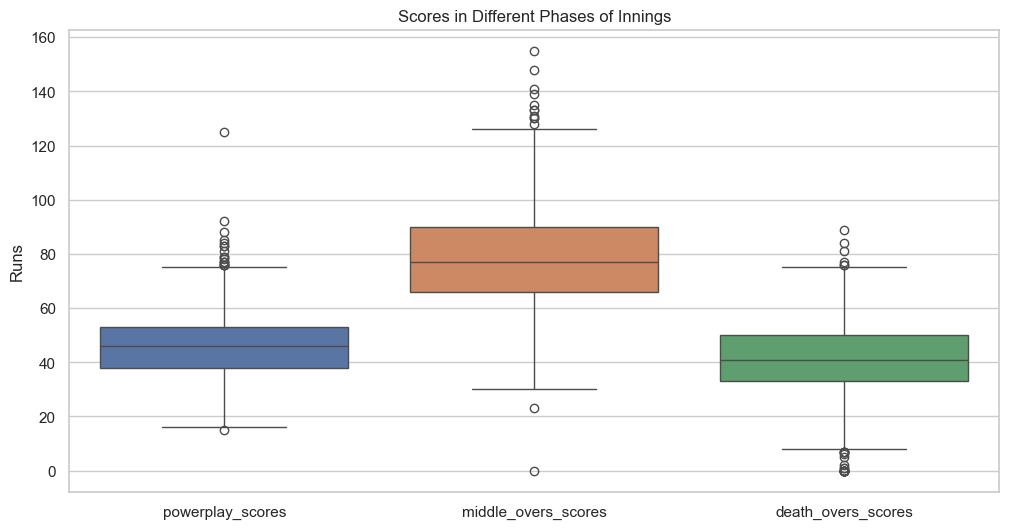

In [19]:
# PERFORMANCE IN DIFFERENT OVERS

pp_md_death = team_info_df[['powerplay_scores', 'middle_overs_scores', 'death_overs_scores']].dropna()

plt.figure()
sns.boxplot(data=pp_md_death)
plt.title('Scores in Different Phases of Innings')
plt.ylabel('Runs')
plt.show()

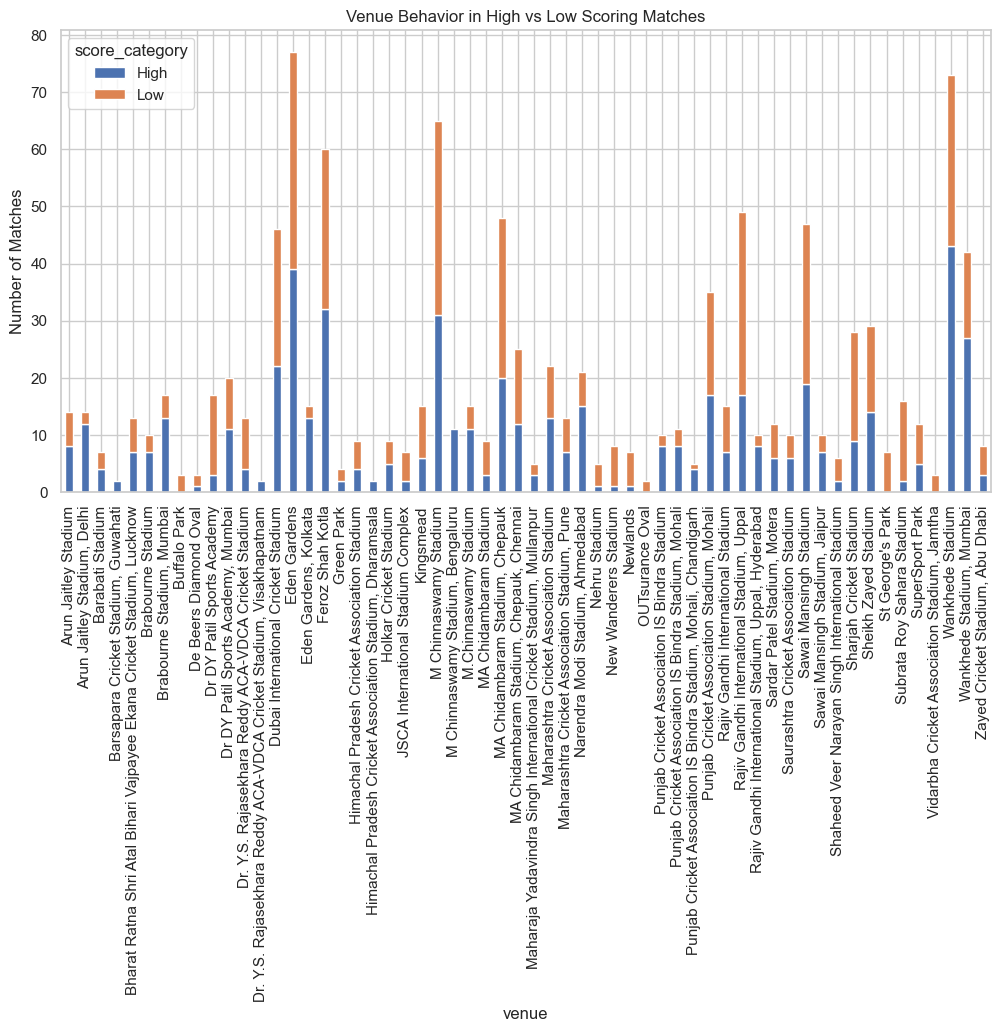

In [20]:
# VENUE BEHAVIOR

team_info_df['total_runs'] = team_info_df['first_innings_score'] + team_info_df['second_innings_score']
median_score = team_info_df['total_runs'].median()
team_info_df['score_category'] = np.where(team_info_df['total_runs'] >= median_score, 'High', 'Low')

venue_summary = team_info_df.groupby(['venue', 'score_category']).size().unstack(fill_value=0)

venue_summary.plot(kind='bar', stacked=True)
plt.title('Venue Behavior in High vs Low Scoring Matches')
plt.ylabel('Number of Matches')
plt.show()

In [21]:
# SIMPLE MATCH WINNER PREDICTOR

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

predictor_df = team_info_df.dropna(subset=['win_type', 'first_innings_score', 'second_innings_score'])
predictor_df['win_type_binary'] = np.where(predictor_df['win_type']=='runs', 1, 0)

X = predictor_df[['first_innings_score', 'second_innings_score']]
y = predictor_df['win_type_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       171
           1       0.98      0.95      0.96       146

    accuracy                           0.97       317
   macro avg       0.97      0.96      0.96       317
weighted avg       0.97      0.97      0.97       317



C:\Users\user5\AppData\Local\Temp\ipykernel_6872\489124771.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor_df['win_type_binary'] = np.where(predictor_df['win_type']=='runs', 1, 0)
